
# Introduction

* Tutorial materials are derived from [_What is torch.nn really?_](https://pytorch.org/tutorials/beginner/nn_tutorial.html) by Jeremy Howard, Rachel Thomas, Francisco Ingham.

In [25]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import model_selection, preprocessing
import torch
from torchvision import datasets

# Getting the CIFAR-10 data

## Downloading the data from GitHub
If you are running this notebook using Google Colab but did not want to bother with setting up a Kaggle account and API key, then you can dowload the data from our GitHub repository by running the code in the following cells.

# Load the CIFAR-10 data

We will work with the same train-test split from yesterday's workshop so that our results will be comparable.

In [86]:
DATA_DIR = pathlib.Path("../data/")
RAW_DATA_DIR = DATA_DIR / "cifar-10"

train_df = pd.read_csv(RAW_DATA_DIR / "train.csv", dtype="uint8")
test_df = pd.read_csv(RAW_DATA_DIR / "test.csv", dtype="uint8")

In [87]:
train_df.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p3063,p3064,p3065,p3066,p3067,p3068,p3069,p3070,p3071,labels
0,215,201,190,187,183,182,184,184,186,189,...,69,69,69,80,88,95,95,95,96,8
1,190,168,148,150,157,158,175,210,217,218,...,116,111,105,111,117,121,119,116,125,7
2,131,126,134,162,173,177,181,183,184,187,...,129,134,137,141,147,152,157,111,48,3
3,162,155,158,161,154,144,151,142,136,136,...,112,115,115,107,116,107,99,94,94,2
4,31,37,47,75,54,44,45,77,143,122,...,109,99,100,100,106,109,111,103,103,4


In [88]:
test_df.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p3063,p3064,p3065,p3066,p3067,p3068,p3069,p3070,p3071,labels
0,124,127,140,152,183,198,198,194,188,167,...,220,219,217,212,204,194,195,205,202,1
1,218,221,222,218,211,210,218,220,215,216,...,18,22,18,13,19,50,64,66,66,9
2,141,108,130,160,158,155,156,159,160,160,...,84,94,37,44,60,65,69,81,52,2
3,208,184,178,176,155,131,130,141,148,158,...,52,61,84,86,89,97,89,90,112,8
4,8,42,44,37,31,19,18,31,54,35,...,99,105,89,77,71,43,47,66,95,4


## Feature scaling

Data for individual pixels is stored as integers between 0 and 255. Neural network models work best when numerical features are scaled. To rescale the raw features we can use tools from the [Scikit-Learn preprocessing module](https://scikit-learn.org/stable/modules/preprocessing.html).

In [127]:
train_features = train_df.drop("labels", axis=1)
train_target = train_df.loc[:, "labels"]

In [128]:
# hyper-parameters
DATA_MIN = 0
DATA_MAX = 1

preprocessor = preprocessing.MinMaxScaler(feature_range=(DATA_MIN, DATA_MAX))

In [129]:
preprocessed_train_features = preprocessor.fit_transform(train_features).astype("float32")
preprocessed_train_target = train_target.values.astype("int64")

## Check out a training sample

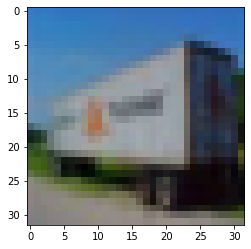

In [117]:
_, ax = plt.subplots(1,1)
X = (preprocessed_train_features[10].reshape((3, 32, 32))
                                    .transpose(1,2,0))
_ = ax.imshow(X)

# Classical ML Benchmark Model

We have several of these from yesterday!

In [ ]:
# TODO load one here!

In [ ]:
accuracy_scores.mean()

# Neural network from scratch

## Split the MNIST data into training and validation sets

Since Kaggle has already split the MNIST data set into training and testing data sets, we only need to split our training data set into training and validation data. We will use the validation data to make sure that we are not over-fitting our models.

In [130]:
SEED = 42
TEST_SIZE = 1e-1
_random_state = np.random.RandomState(SEED)

preprocessed_train_features, preprocessed_val_features, preprocessed_train_target, preprocessed_val_target = (
    model_selection.train_test_split(preprocessed_train_features,
                                     preprocessed_train_target,
                                     test_size=TEST_SIZE,
                                     random_state=_random_state)
)

In [131]:
preprocessed_train_features.shape

(48600, 3072)

In [132]:
preprocessed_val_features.shape

(5400, 3072)


Next let's create a simple model using nothing but [PyTorch tensor operations](https://pytorch.org/docs/stable/tensors.html). PyTorch uses `torch.tensor` rather than `numpy.ndarray` so we need to convert data.

In [133]:
preprocessed_train_target = torch.from_numpy(preprocessed_train_target)
preprocessed_train_features = torch.from_numpy(preprocessed_train_features)

preprocessed_val_target = torch.from_numpy(preprocessed_val_target)
preprocessed_val_features = torch.from_numpy(preprocessed_val_features)

In [134]:
preprocessed_train_features

tensor([[0.3922, 0.3882, 0.4549,  ..., 0.5255, 0.5373, 0.5333],
        [1.0000, 0.9882, 0.9882,  ..., 1.0000, 0.9961, 0.9922],
        [0.9059, 0.9020, 0.9020,  ..., 0.2471, 0.2078, 0.2157],
        ...,
        [0.3216, 0.3451, 0.4314,  ..., 0.3647, 0.3765, 0.3725],
        [0.0078, 0.0078, 0.0078,  ..., 0.0784, 0.1529, 0.0667],
        [0.6941, 0.6863, 0.6863,  ..., 0.1412, 0.0627, 0.0588]])

In [135]:
preprocessed_train_target

tensor([3, 0, 9,  ..., 6, 6, 9])

PyTorch provides methods to create random or zero-filled tensors, which we will use to create our weights and bias for a simple linear model. These are just regular tensors, with one very special addition: we tell PyTorch that they require a gradient. This causes PyTorch to record all of the operations done on the tensor, so that it can calculate the gradient during back-propagation automatically!

For the weights, we set `requires_grad` after the initialization, since we don’t want that step included in the gradient. (Note that a trailling `_` in PyTorch signifies that the operation is performed _in-place_.)

In [185]:
number_samples, number_features = preprocessed_train_features.shape

# using Xavier initialization (divide weights by sqrt(number_features))
weights = torch.randn(number_features, 10) / number_features**0.5
weights.requires_grad_() # trailing underscore indicates in-place operation
bias = torch.zeros(10, requires_grad=True)

Thanks to PyTorch’s ability to calculate gradients automatically, we can use any standard Python function (or callable object) in a model! So we will start by writing a function to peform matrix multiplication and broadcasted addition called `linear_transformation`. We will also need an activation function, so we’ll write a function called `log_softmax_activation` and use it. 

**N.B.** Although PyTorch provides lots of pre-written loss functions, activation functions, and so forth, you can easily write your own using plain python. PyTorch will even create fast GPU or vectorized CPU code for your function automatically.

In [186]:
def linear_transformation(X):
    return X @ weights + bias

def log_softmax_activation(X):
    return X - X.exp().sum(-1).log().unsqueeze(-1)
    
def logistic_regression(X):
    Z = linear_transformation(X)
    return log_softmax_activation(Z)

In the above, the `@` stands for the dot product operation. We will call our function on one batch of data (in this case, 64 images). Note that our predictions won’t be any better than random at this stage, since we start with random weights.

In [187]:
batch_size = 64
output = logistic_regression(preprocessed_train_features[:batch_size])

In [188]:
output[1]

tensor([-1.9024, -0.6430, -2.7019, -2.8654, -3.9908, -2.9894, -3.6719, -2.9764,
        -3.5988, -3.5584], grad_fn=<SelectBackward0>)

As you see, the `output` tensor contains not only the tensor values, but also a gradient function, `grad_fn`. We’ll use this later to do back propagation to update the model parameters.

Let’s implement `negative_log_likelihood` to use as the loss function. Again, we can just use standard Python code.

In [189]:
def negative_log_likelihood(output, target):
    m, _ = output.shape
    return -output[range(m), target].mean()
    

In [190]:
negative_log_likelihood(output, preprocessed_train_target[:batch_size])

tensor(2.3786, grad_fn=<NegBackward0>)

Let’s also implement a function to calculate the `accuracy` of our model: for each prediction, if the index with the largest value matches the target value, then the prediction was correct.

In [191]:
def accuracy(output, target):
    predictions = torch.argmax(output, dim=1)
    return (predictions == target).float().mean()

For comparison purposes we can compute the accuracy of our model with randomly initialized parameters.

In [192]:
accuracy(output, preprocessed_train_target[:batch_size])

tensor(0.1094)

We can now run a training loop. For each iteration, we will:

* select a mini-batch of data (of size `batch_size`)
* use the model to make predictions
* calculate the loss
* `loss.backward()` updates the gradients of the model.

We now use these gradients to update the weights and bias (i.e., model parameters). We do this within the `torch.no_grad()` context manager, because we do not want these actions to be recorded for our next calculation of the gradient. You can read more about how PyTorch’s Autograd records operations [here](https://pytorch.org/docs/stable/notes/autograd.html).

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. loss.backward() adds the gradients to whatever is already stored, rather than replacing them).

In [193]:
model_fn = logistic_regression
loss_fn = negative_log_likelihood

number_epochs = 15
number_batches = (number_samples - 1) // batch_size + 1

learning_rate = 1e-2
for epoch in range(number_epochs):
    for batch in range(number_batches):
        
        # forward pass
        start = batch * batch_size
        X = preprocessed_train_features[start:(start + batch_size)]
        y = preprocessed_train_target[start:(start + batch_size)]
        loss = loss_fn(model_fn(X), y)
        
        # back propagation
        loss.backward()
        with torch.no_grad():
            weights -= learning_rate * weights.grad
            bias -= learning_rate * bias.grad
            weights.grad.zero_()
            bias.grad.zero_()
            

tensor(2.3786, grad_fn=<NegBackward0>)
tensor(5.9554, grad_fn=<NegBackward0>)
tensor(12.8897, grad_fn=<NegBackward0>)
tensor(13.5376, grad_fn=<NegBackward0>)
tensor(22.8779, grad_fn=<NegBackward0>)
tensor(15.1705, grad_fn=<NegBackward0>)
tensor(20.6030, grad_fn=<NegBackward0>)
tensor(28.2064, grad_fn=<NegBackward0>)
tensor(26.2870, grad_fn=<NegBackward0>)
tensor(27.5982, grad_fn=<NegBackward0>)
tensor(22.4894, grad_fn=<NegBackward0>)
tensor(25.0799, grad_fn=<NegBackward0>)
tensor(25.6907, grad_fn=<NegBackward0>)
tensor(27.4782, grad_fn=<NegBackward0>)
tensor(24.7752, grad_fn=<NegBackward0>)
tensor(18.5007, grad_fn=<NegBackward0>)
tensor(22.1925, grad_fn=<NegBackward0>)
tensor(23.1365, grad_fn=<NegBackward0>)
tensor(28.6857, grad_fn=<NegBackward0>)
tensor(25.0975, grad_fn=<NegBackward0>)
tensor(22.3928, grad_fn=<NegBackward0>)
tensor(22.6772, grad_fn=<NegBackward0>)
tensor(26.6228, grad_fn=<NegBackward0>)
tensor(30.8220, grad_fn=<NegBackward0>)
tensor(22.8952, grad_fn=<NegBackward0>)
te

That’s it: we’ve created and trained a minimal neural network (in this case, a logistic regression, since we have no hidden layers) entirely from scratch! Let’s check the loss and accuracy and compare those to what we got earlier. We expect that the loss will have decreased and accuracy to have increased, and they have.

In [194]:
training_loss = loss_fn(model_fn(preprocessed_train_features), preprocessed_train_target)
training_accuracy = accuracy(model_fn(preprocessed_train_features), preprocessed_train_target)

print(f"Training loss: {training_loss}")
print(f"Training accuracy: {training_accuracy}")

Training loss: 8.282297134399414
Training accuracy: 0.23944444954395294


# Refactor using `torch.nn.functional`

We will now refactor our code using [torch.nn](https://pytorch.org/docs/stable/nn.html) modules to make it more concise and flexible. The first and easiest step is to make our code shorter by replacing our hand-written activation and loss functions with those from [torch.nn.functional](https://pytorch.org/docs/stable/nn.html#torch-nn-functional).

Since we are using negative log likelihood loss and log softmax activation in this tutorial, we can use [torch.nn.functional.cross_entropy](https://pytorch.org/docs/stable/nn.html#cross-entropy) which combines the two.

In [195]:
import torch.nn.functional as F

In [197]:
Z = linear_transformation(preprocessed_train_features)
F.cross_entropy(Z, preprocessed_train_target)

tensor(8.2823, grad_fn=<NllLossBackward0>)

# Refactor using `torch.nn.Module`

Next up, we’ll use [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#module) and [torch.nn.Parameter](https://pytorch.org/docs/stable/nn.html#parameters), for a clearer and more concise training loop. In this case, we want to create a class that holds our weights, bias, and method for the forward step. `torch.nn.Module` has a number of attributes and methods (such as `parameters()` and `zero_grad()`) which we will be using.

In [198]:
from torch import nn


class LogisticRegression(nn.Module):
    
    def __init__(self):
        super().__init__()
        self._weights = nn.Parameter(torch.randn(3 * 32 * 32, 10) / (3 * 32 * 32)**0.5)
        self._bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, X):
        return X @ self._weights + self._bias
    


Since we’re now using an object instead of just using a function, we first have to instantiate our model.

In [199]:
model_fn = LogisticRegression()

Now we can calculate the loss in the same way as before. Note that `torch.nn.Module` objects are used as if they are functions (i.e they are callable), but behind the scenes Pytorch will call the `forward` method.

In [201]:
F.cross_entropy(model_fn(preprocessed_train_features), preprocessed_train_target)

tensor(2.4597, grad_fn=<NllLossBackward0>)

Previously in our training loop we had to update the values for each parameter by name and manually zero out the grads for each parameter separately.  With our refactoring we can take advantage of `model_fn.parameters()` and `model_fn.zero_grad()` (which are both defined by PyTorch for `torch.nn.Module` base class!) to make those steps more concise and less prone to the error of forgetting some of our parameters, particularly if we had a more complicated model.

In order to facilitate re-use and continued refactoring, we can encapsulate the logic of our deep learning pipeline in the following functions. 

In [220]:
def partial_fit(model_fn, loss_fn, learning_rate, X_batch, y_batch):
    # forward pass
    loss = loss_fn(model_fn(X_batch), y_batch)

    # back propagation
    loss.backward()
    with torch.no_grad():
        for parameter in model_fn.parameters():
            parameter -= learning_rate * parameter.grad
        model_fn.zero_grad()


def fit(model_fn, loss_fn, X, y, learning_rate=1e-2, number_epochs=2, batch_size=64):
    number_samples, _ = X.shape 
    number_batches = (number_samples - 1) // batch_size + 1
    for epoch in range(number_epochs):
        for batch in range(number_batches):
            start = batch * batch_size
            X_batch = X[start:(start + batch_size)]
            y_batch = y[start:(start + batch_size)]
            partial_fit(model_fn, loss_fn, learning_rate, X_batch, y_batch)

In [221]:
model_fn = LogisticRegression()
loss_fn = F.cross_entropy

In [222]:
fit(model_fn, loss_fn, preprocessed_train_features, preprocessed_train_target, number_epochs=15)

In [223]:
training_loss = loss_fn(model_fn(preprocessed_train_features), preprocessed_train_target)
training_accuracy = accuracy(model_fn(preprocessed_train_features), preprocessed_train_target)

print(f"Training loss: {training_loss}")
print(f"Training accuracy: {training_accuracy}")

Training loss: 1.955792784690857
Training accuracy: 0.31337448954582214


# Refactoring using `torch.nn.Linear`

Instead of defining and initializing `self._weights` and `self._bias`, and calculating `X  @ self._weights + self._bias`, we will instead use the Pytorch class [torch.nn.Linear](https://pytorch.org/docs/stable/nn.html#linear) to define a linear layer which does all that for us. Pytorch has many types of predefined layers that can greatly simplify our code, and since the library code is highly optimized using PyTorch's predefined layers often makes our code faster too.

In [224]:
from torch import nn


class LogisticRegression(nn.Module):
    
    def __init__(self):
        super().__init__()
        self._linear_layer = nn.Linear(3 * 32 * 32, 10)
        
    def forward(self, X):
        return self._linear_layer(X)
    


In [225]:
model_fn = LogisticRegression()
loss_fn = F.cross_entropy

In [226]:
fit(model_fn, loss_fn, preprocessed_train_features, preprocessed_train_target, number_epochs=15)

In [227]:
training_loss = loss_fn(model_fn(preprocessed_train_features), preprocessed_train_target)
training_accuracy = accuracy(model_fn(preprocessed_train_features), preprocessed_train_target)

print(f"Training loss: {training_loss}")
print(f"Training accuracy: {training_accuracy}")

Training loss: 1.952349066734314
Training accuracy: 0.3139917552471161


# Refactoring using `torch.optim`

Pytorch also has a package with various optimization algorithms, [torch.optim](https://pytorch.org/docs/stable/optim.html). We can use the step method from our optimizer to take a forward step, instead of manually updating each parameter. Also note that now the `learning_rate` is a parameter of the optimizer and we do not need to manually pass it as an argument to the `fit` and `partial_fit` functions.

In [228]:
from torch import optim

In [229]:
def partial_fit(model_fn, loss_fn, X_batch, y_batch, opt):
    # forward pass
    loss = loss_fn(model_fn(X_batch), y_batch)

    # back propagation
    loss.backward()
    opt.step()
    opt.zero_grad() # don't forget to reset the gradient after each batch!

        
def fit(model_fn, loss_fn, X, y, opt, number_epochs=2, batch_size=64):
    number_samples, _ = X.shape 
    number_batches = (number_samples - 1) // batch_size + 1
    for epoch in range(number_epochs):
        for batch in range(number_batches):
            start = batch * batch_size
            X_batch = X[start:(start + batch_size)]
            y_batch = y[start:(start + batch_size)]
            partial_fit(model_fn, loss_fn, X_batch, y_batch, opt)

In [230]:
model_fn = LogisticRegression()
loss_fn = F.cross_entropy
opt = optim.SGD(model_fn.parameters(), lr=1e-2)

In [233]:
fit(model_fn, loss_fn, preprocessed_train_features, preprocessed_train_target, opt, number_epochs=15)

In [234]:
training_loss = loss_fn(model_fn(preprocessed_train_features), preprocessed_train_target)
training_accuracy = accuracy(model_fn(preprocessed_train_features), preprocessed_train_target)

print(f"Training loss: {training_loss}")
print(f"Training accuracy: {training_accuracy}")

Training loss: 1.9479228258132935
Training accuracy: 0.3154115080833435


# Refactor using `torch.utils.data.TensorDataSet`

The [torch.utils.data](https://pytorch.org/docs/stable/data.html#module-torch.utils.data) module contains a number of useful classes that we can use to further simplify our code. PyTorch has an abstract `Dataset` class. A Dataset can be anything that has a `__len__` function (called by Python’s standard `len` function) and a `__getitem__` function as a way of indexing into it.

PyTorch’s `TensorDataset` is a `Dataset` wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make it easier to access both the independent and dependent variables in the same line as we train.


In [235]:
from torch.utils import data

In [236]:
def fit(model_fn, loss_fn, data_set, number_samples, opt, number_epochs=2, batch_size=64):
    number_batches = (number_samples - 1) // batch_size + 1
    for epoch in range(number_epochs):
        for batch in range(number_batches):
            start = batch * batch_size
            X_batch, y_batch = data_set[start:(start + batch_size)]
            partial_fit(model_fn, loss_fn, X_batch, y_batch, opt)

In [238]:
model_fn = LogisticRegression()
loss_fn = F.cross_entropy
train_dataset = data.TensorDataset(preprocessed_train_features, preprocessed_train_target)
opt = optim.SGD(model_fn.parameters(), lr=1e-2)

In [240]:
# note the annoying dependence on number of samples!
fit(model_fn, loss_fn, train_dataset, number_samples, opt, number_epochs=15)

In [ ]:
training_loss = loss_fn(model_fn(preprocessed_train_features), preprocessed_train_target)
training_accuracy = accuracy(model_fn(preprocessed_train_features), preprocessed_train_target)

print(f"Training loss: {training_loss}")
print(f"Training accuracy: {training_accuracy}")

# Refactor using `torch.utils.data.DataLoader`

Pytorch’s `DataLoader` is responsible for managing batches. You can create a `DataLoader` from any `Dataset`. `DataLoader` makes it easier to iterate over batches. Rather than having to use `data_set[start:(start + batch_size)]`, the `DataLoader` gives us each minibatch automatically.

In [241]:
def fit(model_fn, loss_fn, data_loader, opt, number_epochs=2, batch_size=64):
    for epoch in range(number_epochs):
        for X_batch, y_batch in data_loader:
            partial_fit(model_fn, loss_fn, X_batch, y_batch, opt)

In [242]:
model_fn = LogisticRegression()
loss_fn = F.cross_entropy
train_data_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
opt = optim.SGD(model_fn.parameters(), lr=1e-2)

In [243]:
# now we no longer have the annoying dependency on number of samples!
fit(model_fn, loss_fn, train_data_loader, opt)

In [244]:
training_loss = loss_fn(model_fn(preprocessed_train_features), preprocessed_train_target)
training_accuracy = accuracy(model_fn(preprocessed_train_features), preprocessed_train_target)

print(f"Training loss: {training_loss}")
print(f"Training accuracy: {training_accuracy}")

Training loss: 1.8355070352554321
Training accuracy: 0.34786006808280945


Thanks to Pytorch’s `torch.nn.Module`, `torch.nn.Parameter`, `Dataset`, and `DataLoader`, our training loop is now dramatically smaller and easier to understand. Let’s now try to add the basic features necessary to create effecive models in practice.

# Adding Validation

In the first part of this tutorial, we were just trying to get a reasonable training loop set up for use on our training data. In reality, you always should also have a validation set, in order to identify if you are overfitting.

Shuffling the training data is important to prevent correlation between batches and overfitting. On the other hand, the validation loss will be identical whether we shuffle the validation set or not. Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We’ll use a batch size for the validation set that is twice as large as that for the training set. This is because the validation set does not need backpropagation and thus takes less memory (it doesn’t need to store the gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.

In [249]:
def validate(epoch, model_fn, loss_fn, val_data_loader):
    model_fn.eval()
    with torch.no_grad():
        batch_losses, batch_sizes = zip(*[(loss_fn(model_fn(X), y), len(X)) for X, y in val_data_loader])
        val_loss = np.sum(np.multiply(batch_losses, batch_sizes)) / np.sum(batch_sizes)
        print(f"Training epoch: {epoch}, Validation loss: {val_loss}")


def fit(model_fn, loss_fn, train_data_loader, opt, val_data_loader=None, number_epochs=2):
    
    for epoch in range(number_epochs):
        model_fn.train()
        for X_batch, y_batch in train_data_loader:
            partial_fit(model_fn, loss_fn, X_batch, y_batch, opt)
        
        # compute validation loss after each training epoch
        if val_data_loader is not None:
            validate(epoch, model_fn, loss_fn, val_data_loader)

In [272]:
model_fn = LogisticRegression()
loss_fn = F.cross_entropy
train_data_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
opt = optim.SGD(model_fn.parameters(), lr=1e-2)

val_dataset = data.TensorDataset(preprocessed_val_features, preprocessed_val_target)
val_data_loader = data.DataLoader(val_dataset, batch_size=64)

In [251]:
fit(model_fn, loss_fn, train_data_loader, opt, val_data_loader, number_epochs=15)

Training epoch: 0, Validation loss: 1.8615815897341128
Training epoch: 1, Validation loss: 1.9743473561604818
Training epoch: 2, Validation loss: 1.9606962945726183
Training epoch: 3, Validation loss: 1.8216497490141126
Training epoch: 4, Validation loss: 1.9630690345057735
Training epoch: 5, Validation loss: 1.8136323639198586
Training epoch: 6, Validation loss: 1.79635711034139
Training epoch: 7, Validation loss: 1.9181257477513065
Training epoch: 8, Validation loss: 1.7693636894226075
Training epoch: 9, Validation loss: 1.8576261440912882
Training epoch: 10, Validation loss: 1.7636663869575218
Training epoch: 11, Validation loss: 1.7866848472312644
Training epoch: 12, Validation loss: 1.8088520267274644
Training epoch: 13, Validation loss: 1.8121466387642755
Training epoch: 14, Validation loss: 1.8352323503847476


In [252]:
training_loss = loss_fn(model_fn(preprocessed_train_features), preprocessed_train_target)
training_accuracy = accuracy(model_fn(preprocessed_train_features), preprocessed_train_target)

print(f"Training loss: {training_loss}")
print(f"Training accuracy: {training_accuracy}")

Training loss: 1.7957079410552979
Training accuracy: 0.36218106746673584


# Switching to CNN

We are now going to build our neural network with three convolutional-subsampling layers. Because none of the functions in the previous section assume anything about the model form, we’ll be able to use them to train a CNN without any modification!

We will use Pytorch’s predefined [torch.nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d) class as our convolutional layer. We define a CNN with 3 convolutional layers. Each convolution is followed by a [torch.nn.functional.relu](https://pytorch.org/docs/stable/nn.html#id26) non-linear activation function and max pooling using [torch.nn.functional.max_pool2d](https://pytorch.org/docs/stable/nn.html#max-pool2d).

After the three convolutional-subsampling layers, we add a couple of densely connected linear layers.

In [262]:
class LeNet5(nn.Module):
    
    def __init__(self):
        super().__init__()
        self._conv1 = nn.Conv2d(3, 50, kernel_size=3, stride=1, padding=1)
        self._conv2 = nn.Conv2d(50, 100, kernel_size=3, stride=1, padding=1)
        self._dense1 = nn.Linear(6400, 100)
        self._dense2 = nn.Linear(100, 10)
        
    def forward(self, X):
        X = X.view(-1, 3, 32, 32) # implicit knowledge of CIFAR-10 data shape!
        X = F.max_pool2d(F.relu(self._conv1(X)), 2)
        X = F.max_pool2d(F.relu(self._conv2(X)), 2)
        X = X.view(X.size(0), -1) # equivalent to Keras flatten layer!
        X = F.relu(self._dense1(X))
        X = self._dense2(X)
        return X
    

In [263]:
model_fn = LeNet5()
opt = optim.Adam(model_fn.parameters())

In [264]:
# note that we can re-use the loss function as well as trainig and validation data loaders
fit(model_fn, loss_fn, train_data_loader, opt, val_data_loader, number_epochs=15)

Training epoch: 0, Validation loss: 1.2447360008734243
Training epoch: 1, Validation loss: 1.0802202874642832
Training epoch: 2, Validation loss: 1.0477342046631708
Training epoch: 3, Validation loss: 0.9046111588124875
Training epoch: 4, Validation loss: 0.9390703868865967
Training epoch: 5, Validation loss: 0.8692001298621849
Training epoch: 6, Validation loss: 0.9229148032047131
Training epoch: 7, Validation loss: 0.8734301625357734
Training epoch: 8, Validation loss: 0.9184626845077232
Training epoch: 9, Validation loss: 0.8985926722155677
Training epoch: 10, Validation loss: 0.934284879763921
Training epoch: 11, Validation loss: 0.9595062609072085
Training epoch: 12, Validation loss: 1.0244469942869963
Training epoch: 13, Validation loss: 1.0199784763654074
Training epoch: 14, Validation loss: 1.0726273963186477


# Refactor using `torch.nn.Sequential`

PyTorch has another handy class we can use to simply our code: [torch.nn.Sequential](https://pytorch.org/docs/stable/nn.html#sequential). A `Sequential` object runs each of the modules contained within it, in a sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a custom layer from a given function. For instance, PyTorch doesn’t have a view layer, and we need to create one for our network. `LambdaLayer` will create a layer that we can then use when defining a network with `Sequential`.

In [265]:
class LambdaLayer(nn.Module):
    
    def __init__(self, f):
        super().__init__()
        self._f = f
        
    def forward(self, X):
        return self._f(X)
    


In [266]:
model_fn = nn.Sequential(
    LambdaLayer(lambda X: X.view(-1, 3, 32, 32)),
    nn.Conv2d(3, 50, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(50, 100, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    LambdaLayer(lambda X: X.view(X.size(0), -1)),
    nn.Linear(6400, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

opt = optim.SGD(model_fn.parameters(), lr=1e-2, momentum=0.9)

In [267]:
fit(model_fn,
    loss_fn,
    train_data_loader,
    opt,
    val_data_loader,
    number_epochs=2)

Training epoch: 0, Validation loss: 1.391805514053062
Training epoch: 1, Validation loss: 1.1363856201701694


# Generalize our pipeline by wrapping our DataLoader

Our CNN is fairly concise, but it only works with CIFAR-10, because it assumes the input is a 3 * 32 * 32 long vector. Let’s get rid of this assumption, so our model works with any three channel image. First, we can remove the initial Lambda layer by moving the data preprocessing into a generator.

In [273]:
class WrappedDataLoader:
    
    def __init__(self, data_loader, f):
        self._data_loader = data_loader
        self._f = f
        
    def __len__(self):
        return len(self._data_loader)
    
    def __iter__(self):
        for batch in iter(self._data_loader):
            yield self._f(*batch)


In [274]:
model_fn = nn.Sequential(
    nn.Conv2d(3, 50, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(50, 100, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    LambdaLayer(lambda X: X.view(X.size(0), -1)),
    nn.Linear(6400, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

opt = optim.SGD(model_fn.parameters(), lr=0.1, momentum=0.9)

_preprocess = lambda X, y: (X.view(-1, 3, 32, 32), y)
train_data_loader = WrappedDataLoader(train_data_loader, _preprocess)
val_data_loader = WrappedDataLoader(val_data_loader, _preprocess)

In [ ]:
fit(model_fn,
    loss_fn,
    train_data_loader,
    opt,
    val_data_loader,
    number_epochs=5)

# Using GPU(s) to accelerate training

GPUs can significantly speedup training of deep neural networks. If you are running this notebook in Google Colab, then you can take advantage of free GPUs to accelerate training of your models! To take advantage of GPU acceleration from the tool bar select `Runtime` -> `Change Runtime Type` and then select `GPU` from the hardware accelerator dropdown menu. **Changing the runtime type requires that the Python kernel be restarted and will require you to re-run relevant cells in the notebook!**

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

In [ ]:
# define your deep learning model and make it available to the GPU
model_fn = nn.Sequential(
    nn.Conv2d(1, 50, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(50, 100, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    LambdaLayer(lambda X: X.view(X.size(0), -1)),
    nn.Linear(4900, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)
model_fn.to(device)

# define a loss
loss_fn = F.cross_entropy

# define an optimizer
opt = optim.Adam(model_fn.parameters())

# create the data loaders
_preprocess = lambda X, y: (X.view(-1, 1, 28, 28).to(device), y.to(device))
training_data_loader = WrappedDataLoader(training_data_loader, _preprocess)
validation_data_loader = WrappedDataLoader(validation_data_loader, _preprocess)

In [ ]:
fit(model_fn,
    loss_fn,
    training_data_loader,
    opt,
    validation_data_loader,
    number_epochs=5)

# Create your own model!

Using the above code as a template, try and create your own deep learning model to classify the MNIST data. Here are a few ideas to try.

1. Add more convolutional layers.
2. Add more neurons in each convolutional layer(s).
3. Try different activation layers.
4. Try using a different optimizer.
5. Try tuning the hyper-parameters of your chosen optimizer.
6. Train the model for more epochs (but don't overfit!)

In [ ]:
model_fn = ???
model_fn.to(device)

opt = ???

In [ ]:
fit(model_fn,
    loss_fn,
    training_data_loader,
    opt,
    validation_data_loader,
    number_epochs=5)